Instalacja niezbędnych bibliotek

In [10]:
# Instalacja bibliotek (wykonaj tylko jeśli biblioteki nie są zainstalowane)
!pip install numpy pandas scikit-learn imbalanced-learn scikit-image matplotlib

# Importowanie potrzebnych bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters
from skimage.filters import frangi
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import os

# Upewnij się, że używasz odpowiednich wersji bibliotek
import sklearn
import skimage
print(f'scikit-learn version: {sklearn.__version__}')
print(f'scikit-image version: {skimage.__version__}')


scikit-learn version: 1.2.2
scikit-image version: 0.19.3


Załadowanie obrazów

In [11]:
# Ścieżki do folderów z obrazami i maskami
images_path = 'images'
manual_path = 'manual'

# Funkcja do ładowania obrazów
def load_images(path, filenames):
    images = []
    for filename in filenames:
        img = io.imread(os.path.join(path, filename))
        images.append(img)
    return images

# Lista nazw plików
filenames = [f'{str(i).zfill(2)}_h.jpg' for i in range(1, 6)]

# Ładowanie obrazów i masek
images = load_images(images_path, filenames)
masks = load_images(manual_path, filenames)


Wstępne przetwarzanie obrazu

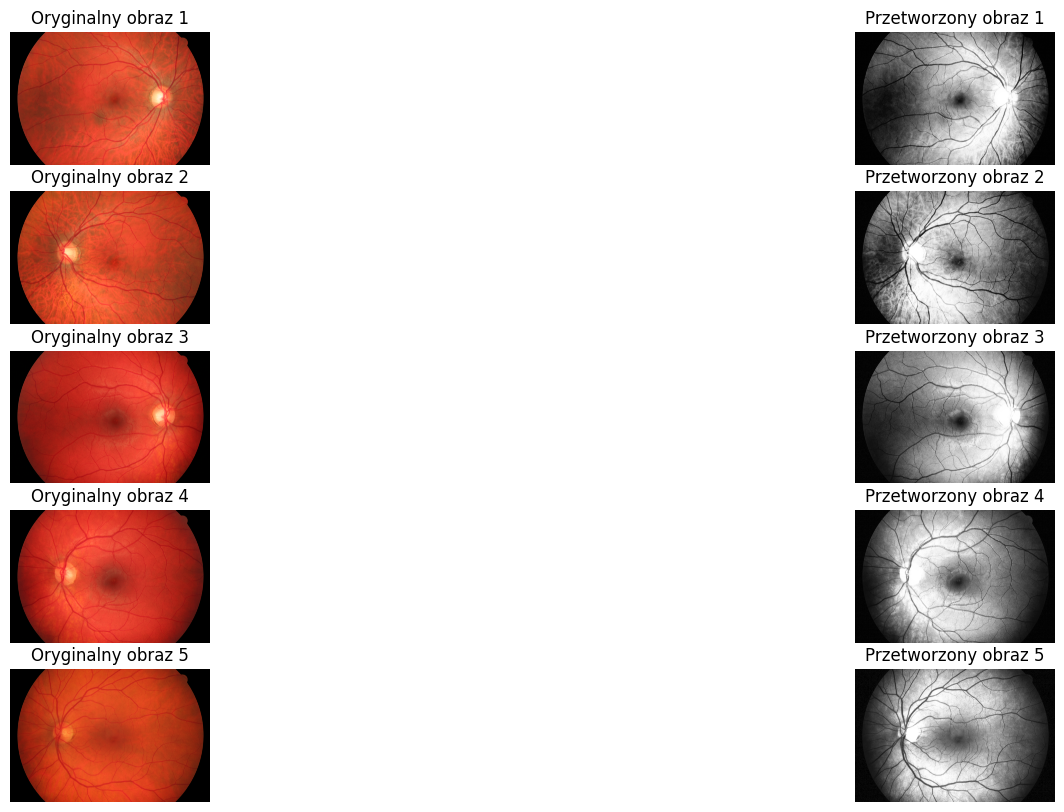

In [12]:
from skimage import exposure, img_as_float

# Funkcja do wstępnego przetwarzania obrazu
def preprocess_image(image):
    # Konwersja do odcieni szarości
    gray_image = color.rgb2gray(image)
    # Konwersja do float
    gray_image = img_as_float(gray_image)
    # Normalizacja histogramu
    image_eq = exposure.equalize_hist(gray_image)
    return image_eq

# Przetwarzanie obrazów
preprocessed_images = [preprocess_image(image) for image in images]

# Funkcja do wyświetlania obrazów i przetworzonych wersji
def display_preprocessed_images(original_images, preprocessed_images):
    num_images = len(original_images)
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.title(f'Oryginalny obraz {i+1}')
        plt.imshow(original_images[i])
        plt.axis('off')

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.title(f'Przetworzony obraz {i+1}')
        plt.imshow(preprocessed_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Wyświetlenie obrazów po wstępnym przetwarzaniu
display_preprocessed_images(images, preprocessed_images)


Zastosowanie filtru Frangi'ego

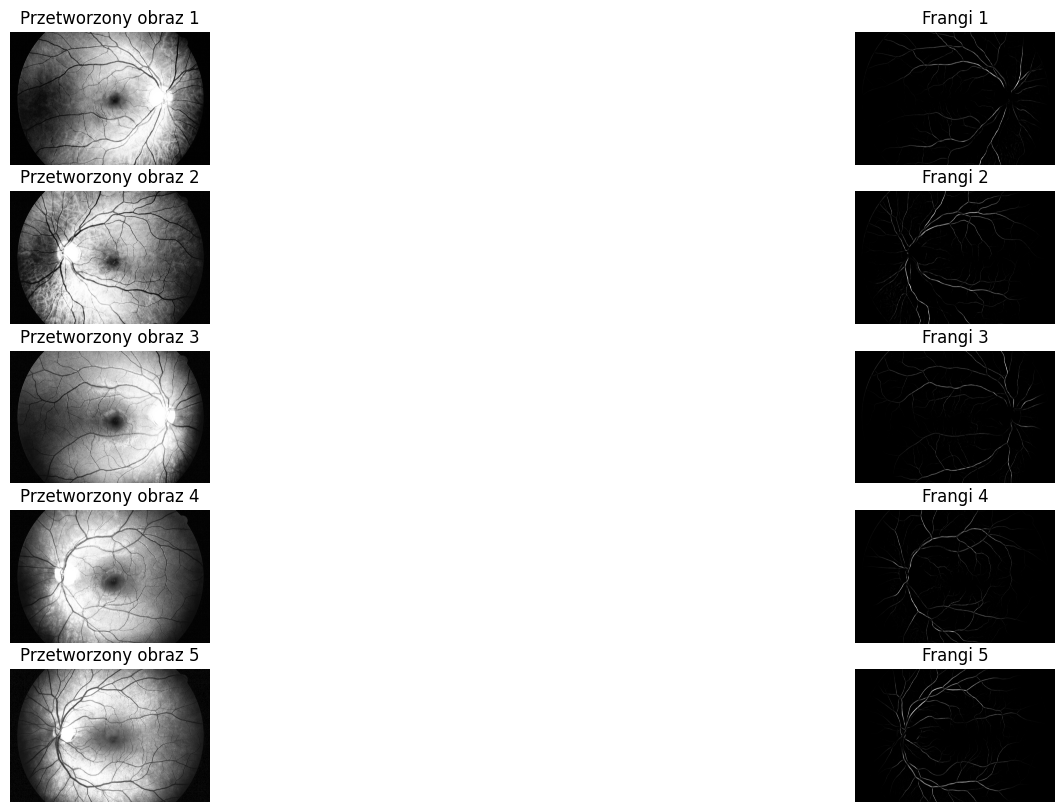

In [13]:
# Funkcja do zastosowania filtru Frangi'ego
def apply_frangi(image):
    return frangi(image)

# Przetwarzanie obrazów za pomocą filtru Frangi'ego
frangi_images = [apply_frangi(image) for image in preprocessed_images]

# Funkcja do wyświetlania wyników filtru Frangi'ego
def display_frangi_images(preprocessed_images, frangi_images):
    num_images = len(preprocessed_images)
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.title(f'Przetworzony obraz {i+1}')
        plt.imshow(preprocessed_images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.title(f'Frangi {i+1}')
        plt.imshow(frangi_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Wyświetlenie obrazów po zastosowaniu filtru Frangi'ego
display_frangi_images(preprocessed_images, frangi_images)


Wyświetlanie masek

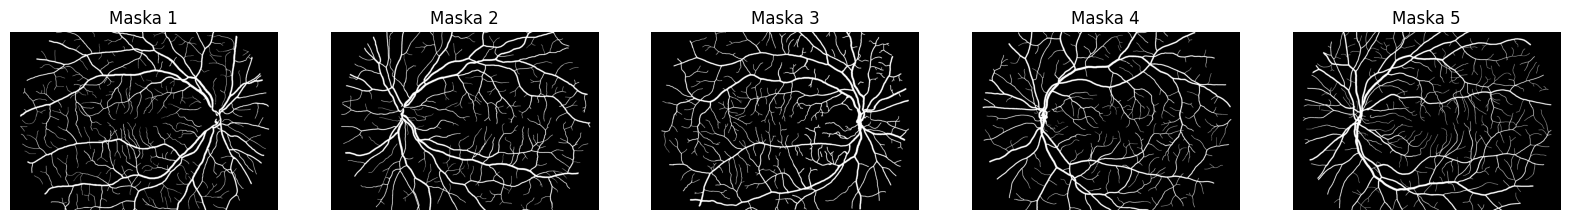

In [14]:
# Funkcja do wyświetlania masek
def display_masks(masks):
    num_images = len(masks)
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.title(f'Maska {i+1}')
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Wyświetlenie masek eksperckich
display_masks(masks)


Progiowanie i usunięcie szumów

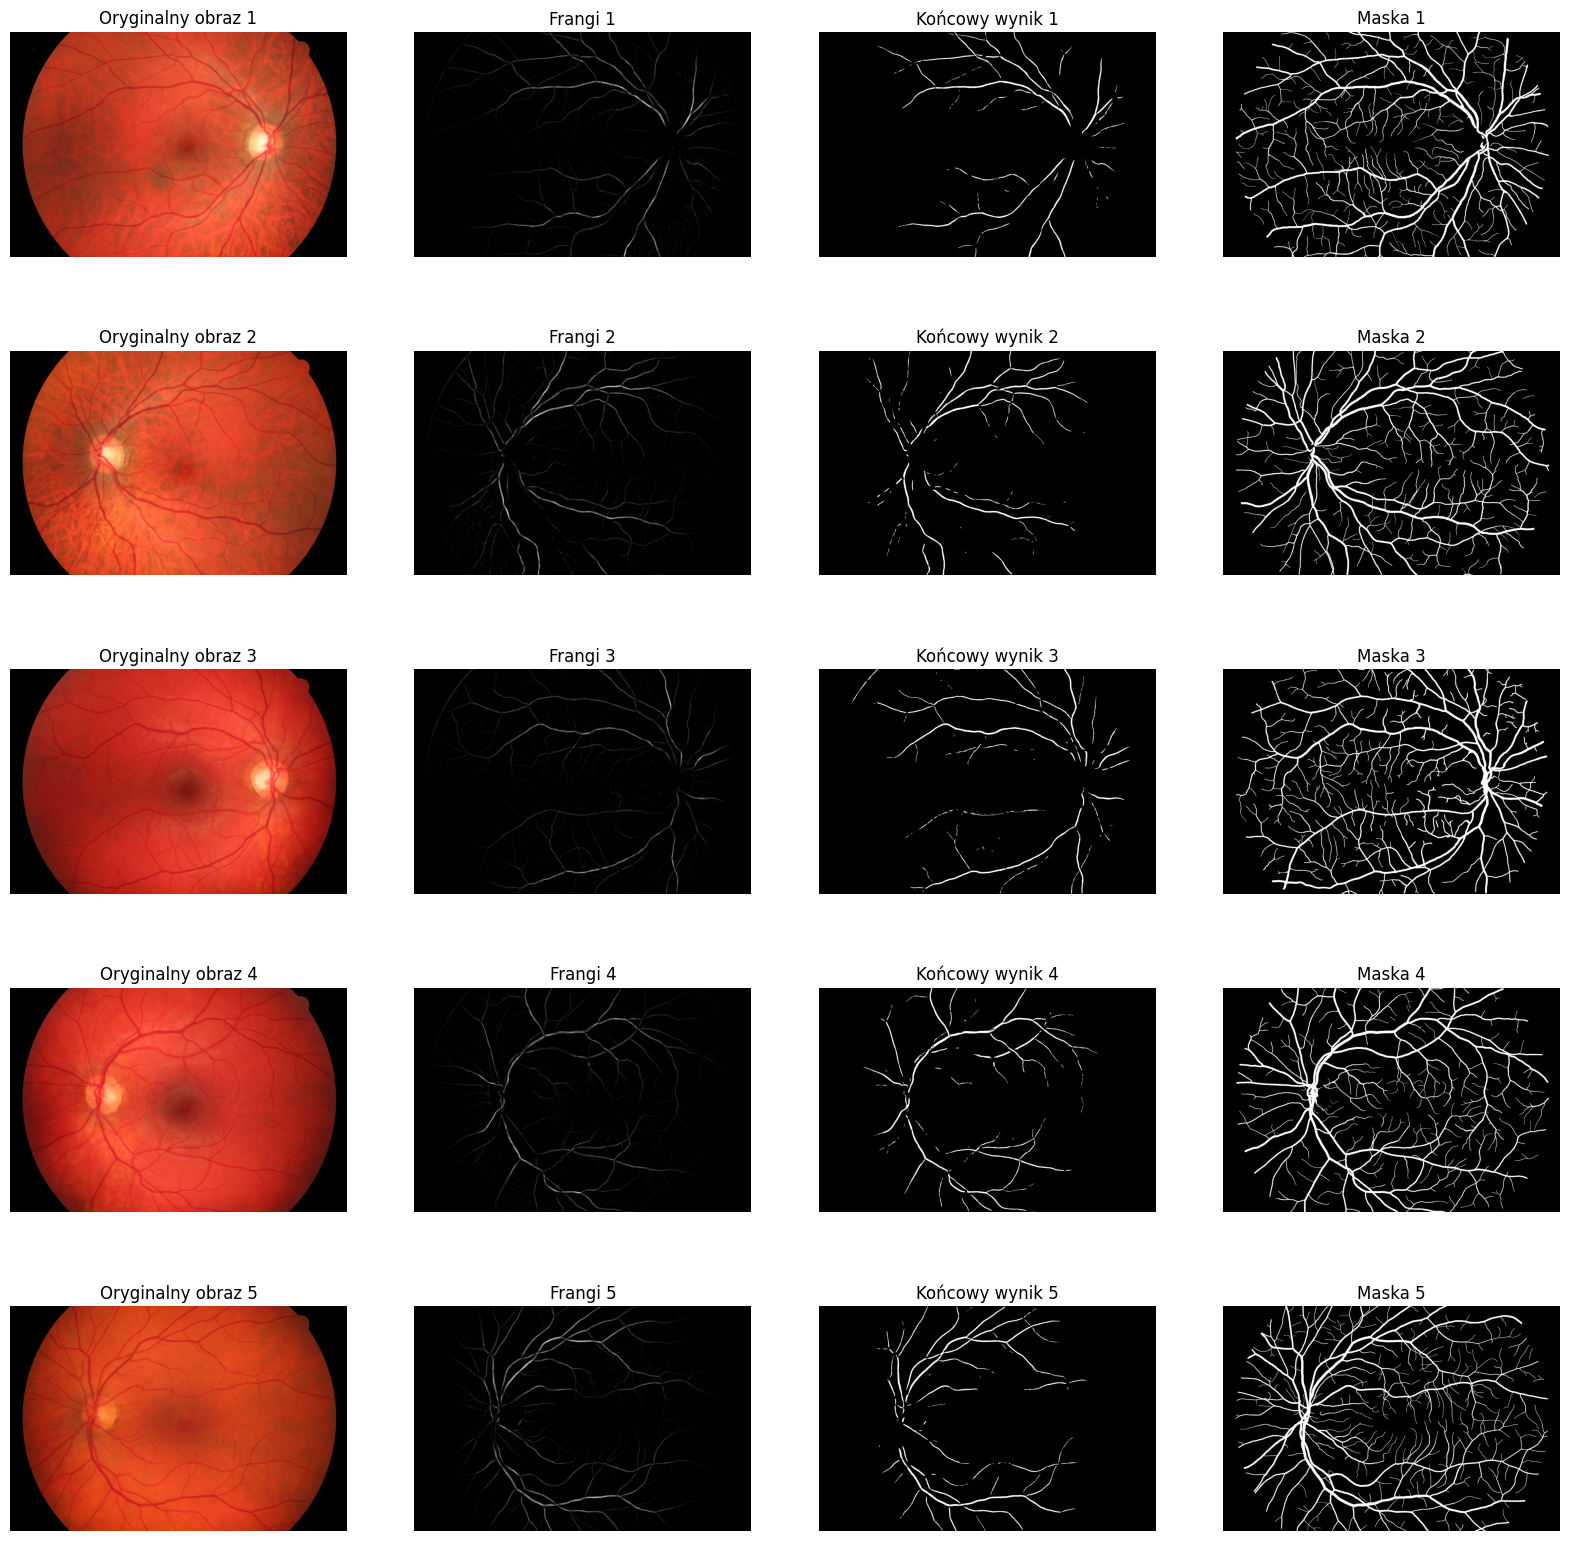

In [17]:
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu

# Funkcja do progiowania i usunięcia szumów
def postprocess_image(image):
    # Progiowanie
    thresh = threshold_otsu(image)
    binary_image = image > thresh
    # Usunięcie małych obiektów
    cleaned_image = remove_small_objects(binary_image, min_size=64)
    return cleaned_image

# Końcowe przetwarzanie obrazów
final_images = [postprocess_image(image) for image in frangi_images]

# Funkcja do wyświetlania wyników końcowego przetwarzania
def display_final_images(original_images, frangi_images, final_images, masks):
    num_images = len(frangi_images)
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(num_images, 4, i * 4 + 1)
        plt.title(f'Oryginalny obraz {i+1}')
        plt.imshow(original_images[i])
        plt.axis('off')

        plt.subplot(num_images, 4, i * 4 + 2)
        plt.title(f'Frangi {i+1}')
        plt.imshow(frangi_images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(num_images, 4, i * 4 + 3)
        plt.title(f'Końcowy wynik {i+1}')
        plt.imshow(final_images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(num_images, 4, i * 4 + 4)
        plt.title(f'Maska {i+1}')
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Wyświetlenie obrazów po końcowym przetwarzaniu
display_final_images(images, frangi_images, final_images, masks)


Analiza wyników

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Funkcja do porównania wyników z maską ekspercką i wyznaczenia miar jakości
def evaluate_segmentation(predicted_masks, expert_masks):
    accuracies = []
    sensitivities = []
    specificities = []

    for pred_mask, exp_mask in zip(predicted_masks, expert_masks):
        # Flatten the masks to compare pixel by pixel
        pred_mask_flat = pred_mask.flatten()
        exp_mask_flat = (exp_mask.flatten() > 0).astype(int)  # assuming mask values are 0 or 255

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(exp_mask_flat, pred_mask_flat).ravel()

        # Calculate accuracy, sensitivity, and specificity
        accuracy = accuracy_score(exp_mask_flat, pred_mask_flat)
        sensitivity = recall_score(exp_mask_flat, pred_mask_flat)  # Sensitivity = Recall
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Specificity calculation

        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        print(f'Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}')
        print(f'Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}\n')

    return accuracies, sensitivities, specificities

# Evaluacja wyników segmentacji
accuracies, sensitivities, specificities = evaluate_segmentation(final_images, masks)

# Wyświetlanie wyników
print("Średnia dokładność:", np.mean(accuracies))
print("Średnia czułość:", np.mean(sensitivities))
print("Średnia swoistość:", np.mean(specificities))


Confusion Matrix: TN=7351213, FP=243, FN=666258, TP=167630
Accuracy: 0.9186, Sensitivity: 0.2010, Specificity: 1.0000

Confusion Matrix: TN=7376032, FP=874, FN=638800, TP=169638
Accuracy: 0.9219, Sensitivity: 0.2098, Specificity: 0.9999

Confusion Matrix: TN=7316827, FP=4346, FN=695483, TP=168688
Accuracy: 0.9145, Sensitivity: 0.1952, Specificity: 0.9994

Confusion Matrix: TN=7412779, FP=964, FN=587142, TP=184459
Accuracy: 0.9282, Sensitivity: 0.2391, Specificity: 0.9999

Confusion Matrix: TN=7354708, FP=766, FN=622376, TP=207494
Accuracy: 0.9239, Sensitivity: 0.2500, Specificity: 0.9999

Średnia dokładność: 0.9213899379183086
Średnia czułość: 0.2190301192989652
Średnia swoistość: 0.9998041355666988


TN (True Negative): Liczba prawidłowo zaklasyfikowanych negatywnych przykładów. W kontekście wykrywania naczyń krwionośnych oznacza to liczbę pikseli, które są tłem (nie naczyniami) i zostały prawidłowo zaklasyfikowane jako tło.

FP (False Positive): Liczba błędnie zaklasyfikowanych negatywnych przykładów. W kontekście wykrywania naczyń krwionośnych oznacza to liczbę pikseli, które są tłem, ale zostały błędnie zaklasyfikowane jako naczynia.

FN (False Negative): Liczba błędnie zaklasyfikowanych pozytywnych przykładów. W kontekście wykrywania naczyń krwionośnych oznacza to liczbę pikseli, które są naczyniami, ale zostały błędnie zaklasyfikowane jako tło.

TP (True Positive): Liczba prawidłowo zaklasyfikowanych pozytywnych przykładów. W kontekście wykrywania naczyń krwionośnych oznacza to liczbę pikseli, które są naczyniami i zostały prawidłowo zaklasyfikowane jako naczynia.